In [2]:
import re
import os
import string
import pickle
import numpy as np
import nltk.corpus
import pandas as pd
import seaborn as sns
from io import StringIO
from sklearn import metrics
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from IPython.display import display
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
# from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
# nltk.download('stopwords')
from nltk.corpus import stopwords
# stemmer = SnowballStemmer("english")

In [4]:
df = pd.read_csv('sample_data.csv')
print(df.shape)

(8428, 4)


In [5]:
df

,Source,Article,Label,Label_id
0,Finsme,"Voyant Photonics, a Long Island City, N.Y.-bas...",Funding,0
1,VCNews Daily,"SEATTLE, WA, Good Therapeutics has raised an $...",Funding,0
2,VCNews Daily,"PLEASANTON, CA, Amador Bioscience, a global tr...",Funding,0
3,Finsme,"Amberstone Biosciences, a Laguna Hills, CA-bas...",Funding,0
4,Crunchbase,Hevo lands $30M for data platform: San Francis...,Funding,0
...,...,...,...,...
8423,PRNewswire -Consumer Products & Retail,Historical Weapons Expert Brian Manifor Appoin...,Noise,4
8424,BusinessJournal,What's next for Orlando's Atrium Management Co...,Noise,4
8425,Businesswire Merger,Terreno Realty Corporation Acquires Property i...,Noise,4
8426,PRNewswire -Energy,Rising Investments in Power Transmission Infra...,Noise,4


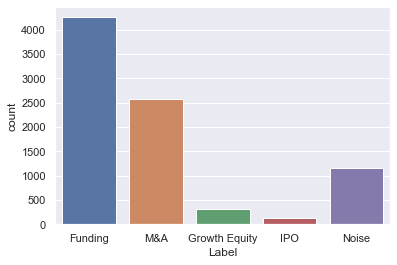

In [6]:
sns.set(style="darkgrid")
ax = sns.countplot(x="Label", data=df)

In [7]:
def clean_text(text):
# lower case
    text = text.lower()
# remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
# removing Unicode
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
# stopwords # stemming
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in (stop)])
    return text




In [8]:
for i in range(len(df.index)):
    article = df.loc[i, 'Article']
    df.loc[i, 'Article'] = clean_text(article)

In [9]:
df

,Source,Article,Label,Label_id
0,Finsme,voyant photonics long island city nybased comp...,Funding,0
1,VCNews Daily,seattle wa good therapeutics raised 8 million ...,Funding,0
2,VCNews Daily,pleasanton ca amador bioscience global transla...,Funding,0
3,Finsme,amberstone biosciences laguna hills cabased bi...,Funding,0
4,Crunchbase,hevo lands 30m data platform san francisco ban...,Funding,0
...,...,...,...,...
8423,PRNewswire -Consumer Products & Retail,historical weapons expert brian manifor appoin...,Noise,4
8424,BusinessJournal,whats next orlandos atrium management co first...,Noise,4
8425,Businesswire Merger,terreno realty corporation acquires property h...,Noise,4
8426,PRNewswire -Energy,rising investments power transmission infrastr...,Noise,4


In [10]:
# df_new = df[['Source','Article', 'Label_id']].copy()

In [11]:
# df_new.head()

In [12]:
# df_new['Label_id'] = df['Label'].factorize()[0]
category_id_df = df[['Label', 'Label_id']].drop_duplicates()

In [13]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Label_id', 'Label']].values)

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each article into a vector
features = tfidf.fit_transform(df.Article).toarray()
labels = df.Label_id
print("Each of the %d Articles is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 8428 Articles is represented by 3685 features (TF-IDF score of unigrams and bigrams)


In [15]:
category_id_df

,Label,Label_id
0,Funding,0
4252,M&A,1
6811,Growth Equity,2
7113,IPO,3
7234,Noise,4


In [16]:
N = 10
for label, label_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("%s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


C:\Users\Venkatesh\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Funding:
  * Most Correlated Unigrams are: round, led, acquire, raised, seed, acquisition, series, funding, acquires, raises
  * Most Correlated Bigrams are: investors including, million funding, series financing, million seed, funding led, completes acquisition, announces acquisition, million series, seed funding, series funding


C:\Users\Venkatesh\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Growth Equity:
  * Most Correlated Unigrams are: strategic, catterton, equity, significant, invests, minority, partners, growth, investment, invested
  * Most Correlated Bigrams are: growth equity, acquired minority, significant investment, announces growth, capital invested, strategic growth, minority stake, announces investment, partners invested, growth investment


C:\Users\Venkatesh\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


IPO:
  * Most Correlated Unigrams are: list, ending, weighing, posted, public, confidentially, bloomberg, net, filed, ipo
  * Most Correlated Bigrams are: deal value, net loss, revenue months, million net, bloomberg deal, ipo plans, list nasdaq, ipo company, plans list, filed ipo


C:\Users\Venkatesh\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


M&A:
  * Most Correlated Unigrams are: disclosed, million, completes, series, acquired, funding, raises, acquire, acquisition, acquires
  * Most Correlated Bigrams are: agreed acquire, million series, agreement acquire, seed funding, series funding, portfolio company, terms disclosed, financial terms, completes acquisition, announces acquisition
Noise:
  * Most Correlated Unigrams are: november, bankruptcy, apartments, pandemic, funding, raises, covid19, ppp, sells, 2020
  * Most Correlated Bigrams are: employed overview, fund announces, initial public, series funding, return capital, capital employed, insider sells, announces pricing, public offering, ppp loans


C:\Users\Venkatesh\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
x = df['Article'] 
y = df['Label_id'] 
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [18]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [19]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [20]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [21]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.904714,0.040610
LogisticRegression,0.903766,0.039574
MultinomialNB,0.863664,0.028916
RandomForestClassifier,0.629448,0.017365


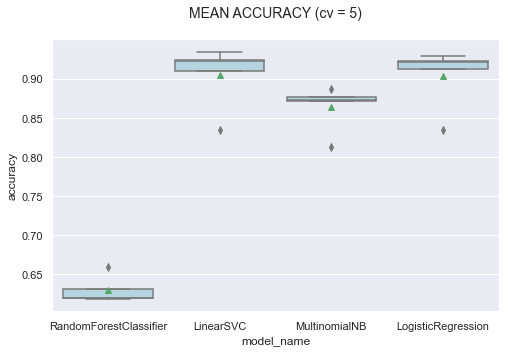

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [71]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [72]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['Label'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

      Funding       0.95      0.97      0.96       826
          M&A       0.92      0.95      0.93       543
Growth Equity       0.78      0.52      0.62        67
          IPO       0.92      0.89      0.91        27
        Noise       0.81      0.74      0.78       223

     accuracy                           0.91      1686
    macro avg       0.87      0.82      0.84      1686
 weighted avg       0.91      0.91      0.91      1686



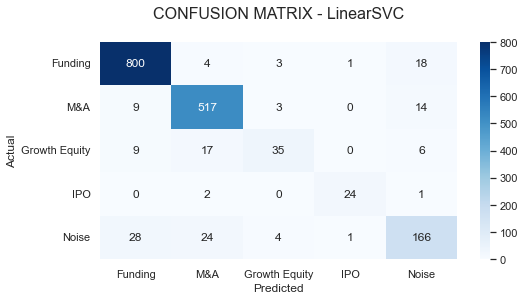

In [73]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            
            xticklabels=category_id_df.Label.values, 
            yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [74]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.05,random_state = 0)

In [75]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english')


In [76]:

fitted_vectorizer = tfidf.fit(X_train.apply(lambda x: clean_text(x)))
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train.apply(lambda x: clean_text(x)))

In [77]:
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [78]:
article = "Cloudflare Buys Vectrix"
pred = model.predict(fitted_vectorizer.transform([article]))
category_id_df.query('Label_id=={}'.format(pred))['Label'].iloc[0]

'M&A'

In [79]:
article = "Liquid Death, a Santa Monica, Calif.-based canned mountain water producer, raised $75 million in series C funding led by Science Ventures and was joined by investors including Live Nation, PowerPlant Partners, Access Capital, and Nomad Ventures."
pred=model.predict(fitted_vectorizer.transform([article]))
category_id_df.query('Label_id=={}'.format(pred))['Label'].iloc[0]

'Funding'

In [101]:
article = ""

pred=model.predict(fitted_vectorizer.transform([article]))
# pred
category_id_df.query('Label_id=={}'.format(pred))['Label'].iloc[0]

'Growth Equity'

In [81]:
category_id_df

,Label,Label_id
0,Funding,0
4252,M&A,1
6811,Growth Equity,2
7113,IPO,3
7234,Noise,4


In [82]:
filename = 'pickle_file_test.pkl'
with open(filename, 'wb') as fout:
    pickle.dump((model, fitted_vectorizer), fout)